## Setup

- validate/test differently?

In [1]:
import numpy as np
import pandas as pd

In [2]:
# If memory growth is enabled for a PhysicalDevice,
# the runtime initialization will not allocate all memory on the device. 
# Memory growth cannot be configured on a PhysicalDevice with virtual devices configured.
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

2021-09-26 01:06:53.853071: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-09-26 01:06:55.501604: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-26 01:06:55.502206: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-26 01:06:55.616013: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:08:00.0 name: NVIDIA GeForce RTX 2080 SUPER computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 462.00GiB/s
2021-09-26 01:06:55.616991: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:41:00.0 name: NVIDIA GeForce RTX 2080 SUPER computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 7.79GiB deviceMemoryBandwidth:

In [3]:
from keras.optimizers import SGD 


from keras.layers import TimeDistributed
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from keras.metrics import top_k_categorical_accuracy

In [4]:
# multivariate one step problem
from numpy import array, insert, hstack, delete
from keras.preprocessing.sequence import TimeseriesGenerator

In [5]:
import warnings
warnings.filterwarnings('ignore')

## Data Prep

In [114]:
from datetime import datetime
# dateparse = lambda x, y: datetime.strptime(x+" "+y, '%m/%d/%Y %H:%M:%S')
df = pd.read_csv("../data/historical.csv")
# , parse_dates={'datetime': ['Date', 'Time']}, date_parser=dateparse)

In [38]:
date_lengths = df.Date.str.len()
date_lengths.value_counts()

10    23409
24        3
Name: Date, dtype: int64

In [39]:
indices = np.where([date_lengths == 24])[1]
df.iloc[indices][["Date", "Time"]] # weird format

,Date,Time
3378,1975-02-23T02:58:41.000Z,1975-02-23T02:58:41.000Z
7512,1985-04-28T02:53:41.530Z,1985-04-28T02:53:41.530Z
20650,2011-03-13T02:23:34.520Z,2011-03-13T02:23:34.520Z


In [40]:
df.loc[3378, 'Date'] = "02/23/1975"
df.loc[3378, 'Time'] = "02:53:41"

df.loc[7512, 'Date'] = "04/28/1985"
df.loc[7512, 'Time'] = "02:53:41"

df.loc[20650, 'Date'] = "03/13/2011"
df.loc[20650, 'Time'] = "02:23:34"

In [41]:
df["time"] = df["Date"]+"_"+df["Time"]

In [42]:
df['time'] =  pd.to_datetime(df['time'], format='%m/%d/%Y_%H:%M:%S')

In [43]:
df.sort_values("time", inplace=True)
df.set_axis(df['time'], inplace=True)

In [44]:
# trim to magnitude
MINIMUM_MAGNITUDE = 5
df = df[df["Magnitude"]>=MINIMUM_MAGNITUDE]

In [45]:
time_range = df.time.to_numpy() # for plotting...

In [46]:
df.head(1)

,Date,Time,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,...,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status,time
time,,,,,,,,,,,,,,,,,,,,,
1965-01-02 13:44:18,01/02/1965,13:44:18,19.246,145.616,Earthquake,131.6,NaN,NaN,6.0,MW,...,NaN,NaN,NaN,NaN,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic,1965-01-02 13:44:18


In [47]:
cols = ["Longitude", "Latitude", "Magnitude"]#, "impact.significance", "location.depth"]
df = df[cols]
df.rename(dict(zip(cols, ["longitude", "latitude", "magnitude"])), 
          axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)
df

,longitude,latitude,magnitude
0,145.6160,19.2460,6.0
1,127.3520,1.8630,5.8
2,-173.9720,-20.5790,6.2
3,-23.5570,-59.0760,5.8
4,126.4270,11.9380,5.8
...,...,...,...
23407,-118.8941,38.3917,5.6
23408,-118.8957,38.3777,5.5
23409,140.4262,36.9179,5.9
23410,118.6639,-9.0283,6.3


In [48]:
import geohash as gh

In [51]:
df["geohash"] = df.apply(lambda x: gh.encode(x["latitude"], x["longitude"], precision=2), axis = 1)
df

,longitude,latitude,magnitude,geohash
0,145.6160,19.2460,6.0,x5
1,127.3520,1.8630,5.8,wb
2,-173.9720,-20.5790,6.2,2h
3,-23.5570,-59.0760,5.8,5m
4,126.4270,11.9380,5.8,wf
...,...,...,...,...
23407,-118.8941,38.3917,5.6,9q
23408,-118.8957,38.3777,5.5,9q
23409,140.4262,36.9179,5.9,xn
23410,118.6639,-9.0283,6.3,qw


In [52]:
# integer encode (DO NOT DO IF 1-hot encoding... ??)
df["geohash_idx"] =  pd.Categorical(df.geohash).codes

In [60]:
geohash_idx2hash = dict(zip(df.geohash_idx, df.geohash))

In [61]:
CLASS_COUNT = df["geohash_idx"].nunique() # is number of unique classes
CLASS_COUNT

424

In [62]:
df.drop(["latitude", "longitude"], axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)

In [63]:
df.head(3)

,magnitude,geohash,geohash_idx
0,6.0,x5,385
1,5.8,wb,358
2,6.2,2h,17


## Modeling

In [73]:
y = df["geohash_idx"].to_numpy()
y = y.reshape((-1, 1))
len(y)

23412

In [74]:
y[0]

array([385], dtype=int16)

In [75]:
# for plotting... (x axis)
# date_train = time_range[:split_idx]
# date_test = time_range[split_idx:]
# len(date_train), len(date_test)

Running the example prints the input and output portions of the samples with the output values for the next time step rather than the current time step as we may desire for this type of problem.

https://machinelearningmastery.com/how-to-use-the-timeseriesgenerator-for-time-series-forecasting-in-keras/

For a stateful LSTM, the batch size should be chosen in a way, so that the number of samples is divisible by the batch size. See also here:

Keras: What if the size of data is not divisible by batch_size?

In your case, considering that you take 20% from your training data as a validation set, you have 1136 samples remaining. So you should choose a batch size by which 1136 is divisible.

Additionally, you could for example remove some samples or reuse samples to be able to choose various batch sizes.

In [76]:
# need to choose batch size so that n/batch_size remainder is memory (timesteps/events looking back)
# want larger batch size for model performance so wrote wrapper func to help find


# train/test split
for train_proportion in list(range(70, 90, 1)):
    train_proportion /= 100
    split_idx = int(train_proportion*len(y))
    geo_train = y[:split_idx]
    geo_test = y[split_idx:]


    for MEMORY in list(range(1, 10)):
        def print_factors(data_ct, MEMORY):
            return {batch_size for batch_size in range(1, data_ct+1) 
                        if data_ct % batch_size == MEMORY}

        train_batch_sizes = print_factors(len(geo_train), MEMORY)
        test_batch_sizes = print_factors(len(geo_test), MEMORY)


        common_sizes = train_batch_sizes.intersection(test_batch_sizes)
        if len(common_sizes)>=1:
            print(f"TT SPLIT: {train_proportion} | MEMORY: {MEMORY} | COMMON BATCH SIZES: {common_sizes}")

TT SPLIT: 0.7 | MEMORY: 1 | COMMON BATCH SIZES: {2341}
TT SPLIT: 0.71 | MEMORY: 2 | COMMON BATCH SIZES: {4}
TT SPLIT: 0.71 | MEMORY: 6 | COMMON BATCH SIZES: {8}
TT SPLIT: 0.72 | MEMORY: 1 | COMMON BATCH SIZES: {5}
TT SPLIT: 0.72 | MEMORY: 6 | COMMON BATCH SIZES: {25, 10, 50}
TT SPLIT: 0.73 | MEMORY: 2 | COMMON BATCH SIZES: {8, 16, 4}
TT SPLIT: 0.75 | MEMORY: 1 | COMMON BATCH SIZES: {2}
TT SPLIT: 0.75 | MEMORY: 3 | COMMON BATCH SIZES: {6}
TT SPLIT: 0.76 | MEMORY: 1 | COMMON BATCH SIZES: {2}
TT SPLIT: 0.76 | MEMORY: 3 | COMMON BATCH SIZES: {6}
TT SPLIT: 0.77 | MEMORY: 1 | COMMON BATCH SIZES: {2}
TT SPLIT: 0.77 | MEMORY: 2 | COMMON BATCH SIZES: {7}
TT SPLIT: 0.77 | MEMORY: 3 | COMMON BATCH SIZES: {6}
TT SPLIT: 0.77 | MEMORY: 9 | COMMON BATCH SIZES: {42, 21, 14}
TT SPLIT: 0.78 | MEMORY: 1 | COMMON BATCH SIZES: {2, 10, 5}
TT SPLIT: 0.78 | MEMORY: 2 | COMMON BATCH SIZES: {19}
TT SPLIT: 0.78 | MEMORY: 3 | COMMON BATCH SIZES: {6}
TT SPLIT: 0.78 | MEMORY: 6 | COMMON BATCH SIZES: {15}
TT SPLIT: 

In [96]:
train_proportion = .77
split_idx = int(train_proportion*len(y))
geo_train = y[:split_idx]
geo_test = y[split_idx:]

In [97]:
MEMORY = 9
BATCH_SIZE = 42

train_generator = TimeseriesGenerator(geo_train, geo_train, length=MEMORY, batch_size=BATCH_SIZE)

In [99]:
DROPOUT = .6
EPOCHS = 10
ACTIVATION = "tanh"
ALPHA = 1e-06
UNITS = 64

feature_ct = geo_train.shape[1]

I do not use validation sets for time series forecasting, I don’t see a straightforward way to implement it.



In [100]:
model = Sequential()

# did not 1-hot encode since using  sparse loss
batchsize__input_dim = (BATCH_SIZE, MEMORY, feature_ct) 
model.add(LSTM(UNITS, 
               activation=ACTIVATION, 
               batch_input_shape=batchsize__input_dim, 
               return_sequences=True, 
               stateful=True, 
               name="input_lstm",
               recurrent_dropout=DROPOUT
              )) 

model.add(LSTM(UNITS, 
               activation=ACTIVATION,
               recurrent_dropout=DROPOUT,
               return_sequences=False,
              ))

model.add(Dropout(DROPOUT))

model.add(Dense(CLASS_COUNT, activation="softmax"))

def top_k_metric(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=10) 



from keras import optimizers
optimizer = optimizers.Adam(learning_rate=ALPHA)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, 
              sample_weight_mode="temporal",
              metrics=[top_k_metric, "sparse_categorical_accuracy"])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_lstm (LSTM)            (42, 9, 64)               16896     
_________________________________________________________________
lstm_4 (LSTM)                (42, 64)                  33024     
_________________________________________________________________
dropout_4 (Dropout)          (42, 64)                  0         
_________________________________________________________________
dense_4 (Dense)              (42, 424)                 27560     
Total params: 77,480
Trainable params: 77,480
Non-trainable params: 0
_________________________________________________________________


In [101]:
for i in range(EPOCHS):
    print()
    
    model.fit_generator(train_generator, epochs=1, shuffle=False)
    model.reset_states()


429/429 [==============================] - 11s 23ms/step - loss: 6.0583 - top_k_metric: 0.0127 - sparse_categorical_accuracy: 0.0032

429/429 [==============================] - 10s 23ms/step - loss: 6.0521 - top_k_metric: 0.0144 - sparse_categorical_accuracy: 0.0037

429/429 [==============================] - 9s 22ms/step - loss: 6.0486 - top_k_metric: 0.0131 - sparse_categorical_accuracy: 0.0034

429/429 [==============================] - 10s 23ms/step - loss: 6.0420 - top_k_metric: 0.0133 - sparse_categorical_accuracy: 0.0039

429/429 [==============================] - 10s 22ms/step - loss: 6.0375 - top_k_metric: 0.0136 - sparse_categorical_accuracy: 0.0040

429/429 [==============================] - 10s 23ms/step - loss: 6.0324 - top_k_metric: 0.0114 - sparse_categorical_accuracy: 0.0041

429/429 [==============================] - 10s 23ms/step - loss: 6.0284 - top_k_metric: 0.0114 - sparse_categorical_accuracy: 0.0049

429/429 [==============================] - 10s 23ms/step - los

One big difference between regular regression models and time series models is how we run predictions. The first one should be pretty obvious, we take the last 12 months of train data and predict it to get the first test data.
How do we predict the next one?
This is a big issue esp. if you take a shortcut and use the test data’s first value and use that as your last prediction. That way you are feeding the correct values for the prior steps helping the model to create better results that it would otherwise give.
What needs to happen is that the “first prediction” needs to be added to the last 11 training data to create a new set of 12 data points to predict the next one. This way we are not cheating at all, the test data is really test data and is never seen by the model.

this post wasn't worth saving tho...

In [105]:
# trimming slightly to fit batch size
test_generator = TimeseriesGenerator(geo_test, geo_test, length=MEMORY, batch_size=BATCH_SIZE)
prediction = model.predict_generator(test_generator, verbose=1)
prediction.shape

128/128 [==============================] - 1s 6ms/step


(5376, 424)

In [106]:
max_index_col = np.argmax(prediction, axis=1)
set(max_index_col) # the different indices that were max (output neurons that lit up the most)

{14, 17, 143, 257, 374}

In [109]:
lat__long = [gh.decode(geohash_idx2hash[e]) for e in max_index_col] # make sure right way around!
# make sure proper order
# make sure unpacks index per model lines up. MOVE ON IGNORE DEETS!
prediction_df = pd.DataFrame(lat__long, columns=["latitude", "longitude"])
prediction_df.drop_duplicates(inplace=True)
prediction_df.reset_index(drop=True)
prediction_df

,latitude,longitude
0,25.3125,129.375
14,-14.0625,118.125
26,30.9375,-61.875
225,-19.6875,-174.375
1801,-30.9375,-174.375


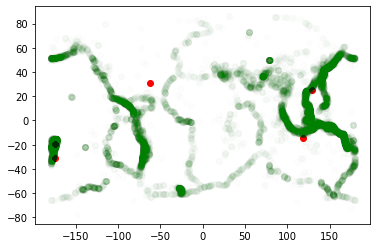

In [120]:
import matplotlib.pyplot as plt
plt.scatter(x=prediction_df['longitude'], y=prediction_df['latitude'], color="red")

huh = df[["Latitude", "Longitude"]].drop_duplicates()
plt.scatter(x=huh['Longitude'], y=huh['Latitude'], color="green", alpha=.01)
plt.show()

Assuming that the algorithms have a hard time to interpret GPS coordinates, the system
could instead use encoded positions. This approach would take a latitude and longitude position and with a defined precision hash it and save it in a dictionary. This precision would
be the amount of decimals for the latitude and longitude to use. This would discretize the
operating area into a grid where the interval depends on the chosen precision.
The drawback of this approach is with higher precision and operating area, the exponentially more locations have to hashed and stored. A small area of radius ten kilometre and
4 decimal precision could yield well over 300000 locations and therefore outcomes. Another
drawback is that the algorithm can only use positions it have trained on.


need to 1-hjot encode since no ordinal relation exists